# Predict Stock Price Using Orbit

Description

## 1. Prerequisites

Following are prerequisite for this tutorial:

- Stock Price Data
- Python Package: Uber Orbit
- Python Package: pandas-datareader

### 1.1. Stock Price Data

Daily Stock Price Data is sourced from Yahoo using pandas-datareader.

### 1.2. Python Packages

#### 1.2.1. pandas-datareader

In [1]:
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 24.3 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


#### 1.2.2. Uber Orbit

In [2]:
!pip install --upgrade orbit-ml=="1.1.1"

     |████████████████████████████████| 466 kB 24.3 MB/s 
     |████████████████████████████████| 1.6 MB 52.6 MB/s 
     |████████████████████████████████| 67.3 MB 283 kB/s 
     |████████████████████████████████| 718 kB 64.5 MB/s 
     |████████████████████████████████| 9.8 MB 49.2 MB/s 
     |████████████████████████████████| 4.6 MB 59.2 MB/s 
     |████████████████████████████████| 845 kB 75.6 MB/s 
     |████████████████████████████████| 1.9 MB 54.0 MB/s 
     |████████████████████████████████| 233 kB 56.4 MB/s 
     |████████████████████████████████| 229 kB 88.2 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## 2. Code

### 2.1. Import Python Packages

Import python packages and show its version. Showing version is important since it will enable other users to replicate your work using same python version and python packages version.

In [3]:
import pandas as pd
import matplotlib as plt
import platform

import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas_datareader
from pandas_datareader import data as web

import orbit
from orbit.models import DLT
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data,plot_predicted_components, plot_bt_predictions
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.diagnostics.metrics import smape, wmape

print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('matplotlib: ', plt.__version__)
print('statsmodels: ', statsmodels.__version__)
print('pandas_datareader: ', pandas_datareader.__version__)
print('Orbit: ', orbit.__version__)

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:matplotlib.font_manager:generated new fontManager
Python:  3.7.12
pandas:  1.2.5
matplotlib:  3.5.1
statsmodels:  0.13.2
pandas_datareader:  0.10.0
Orbit:  1.1.1


### 2.2. Import Stock Price Data from Yahoo Finance

We will be forecasting stock price of AMD where we will use NASDAQ price or QQQ as a regressor. We will be pulling 1 year of stock price data of both AMD and QQQ where we will use first 6 months of stock price data to train the model and second 6 months of stock price data to test and validate the model performance.

In [4]:
stock_price_period = date.today() + relativedelta(months=-12)

stock_price = web.DataReader('AMD', 'yahoo', stock_price_period)
stock_price.reset_index(inplace=True)
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       253 non-null    datetime64[ns]
 1   High       253 non-null    float64       
 2   Low        253 non-null    float64       
 3   Open       253 non-null    float64       
 4   Close      253 non-null    float64       
 5   Volume     253 non-null    int64         
 6   Adj Close  253 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 14.0 KB


In [5]:
nasdaq_price = web.DataReader('QQQ', 'yahoo', stock_price_period)
nasdaq_price.reset_index(inplace=True)
nasdaq_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       253 non-null    datetime64[ns]
 1   High       253 non-null    float64       
 2   Low        253 non-null    float64       
 3   Open       253 non-null    float64       
 4   Close      253 non-null    float64       
 5   Volume     253 non-null    float64       
 6   Adj Close  253 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 14.0 KB


### 2.3. Prep Stock Price Data

To simplify the data prep steps, we will drop columns we will not use from nasdaq_price dataframe as well as rename 'Adj Close' to 'nadaq' since stock_price dataframe also has 'Adj Close' column name.

In [6]:
nasdaq_price = nasdaq_price[['Date', 'Adj Close']]
nasdaq_price.rename(columns={'Adj Close': 'nasdaq'}, inplace=True)
nasdaq_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    253 non-null    datetime64[ns]
 1   nasdaq  253 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


We will join both stock_price dataframe and nasdaq_price dataframe on 'Date'

In [7]:
stock_price = pd.merge(stock_price, nasdaq_price, on='Date', how="left")
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253 entries, 0 to 252
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       253 non-null    datetime64[ns]
 1   High       253 non-null    float64       
 2   Low        253 non-null    float64       
 3   Open       253 non-null    float64       
 4   Close      253 non-null    float64       
 5   Volume     253 non-null    int64         
 6   Adj Close  253 non-null    float64       
 7   nasdaq     253 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 17.8 KB


We will name 'Adj Close' to 'adj_close' since I really do not like to having a space in column name.

In [8]:
stock_price.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
stock_price.head(5)

,Date,High,Low,Open,Close,Volume,adj_close,nasdaq
0,2021-04-30,84.099998,81.419998,82.970001,81.620003,46601900,81.620003,336.378448
1,2021-05-03,82.000000,78.459999,81.970001,78.550003,66323300,78.550003,334.587097
2,2021-05-04,78.669998,77.040001,77.949997,78.610001,59194300,78.610001,328.565948
3,2021-05-05,79.300003,77.360001,79.050003,77.830002,42310200,77.830002,327.461212
4,2021-05-06,78.059998,76.470001,77.629997,77.889999,38661300,77.889999,329.929382


Let's split the dataset evenly to both train and test:

- train dataset
- test dataset

In [9]:
stock_price_train = stock_price[:-126]
stock_price_test = stock_price[-126:]

print('Train: ', stock_price_train.shape)
print('Test: ', stock_price_test.shape)

Train:  (127, 8)
Test:  (126, 8)


### 2.4. Develop Local Global Trend (LGT) Forecast Model

LGT stands for Local and Global Trend and is a refined model from Rlgt (Smyl et al., 2019). The main difference is that LGT is an additive form taking log-transformation response as the modeling response. This essentially converts the model into a multiplicative with some advantages (Ng and Wang et al., 2020). However, one drawback of this approach is that negative response values are not allowed due to the existence of the global trend term and because of that we start to deprecate the support of regression of this model per Orbit website.

In [10]:
%%time
stock_price_lgt = LGT(
  response_col='adj_close', 
  date_col='Date',  
  regressor_col=['nasdaq'],
)
stock_price_lgt.fit(df=stock_price_train)

/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:251: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d372bb7bc77e1df83218127fc9dd707d NOW.
CPU times: user 1.26 s, sys: 118 ms, total: 1.37 s
Wall time: 1min 56s


In [11]:
stock_price_predicted = stock_price_lgt.predict(df=stock_price_test, decompose=True)

/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')


#### 2.4.1. Chart LGT Forecast Model

This LGT Forecast Model is not expected to perform well to predict stock price for 6 month, but we are not trying to develop a forecast model to predict stock price for 6 months. We are trying to develop a forecast model to predict stock price for 1 to 5 days.

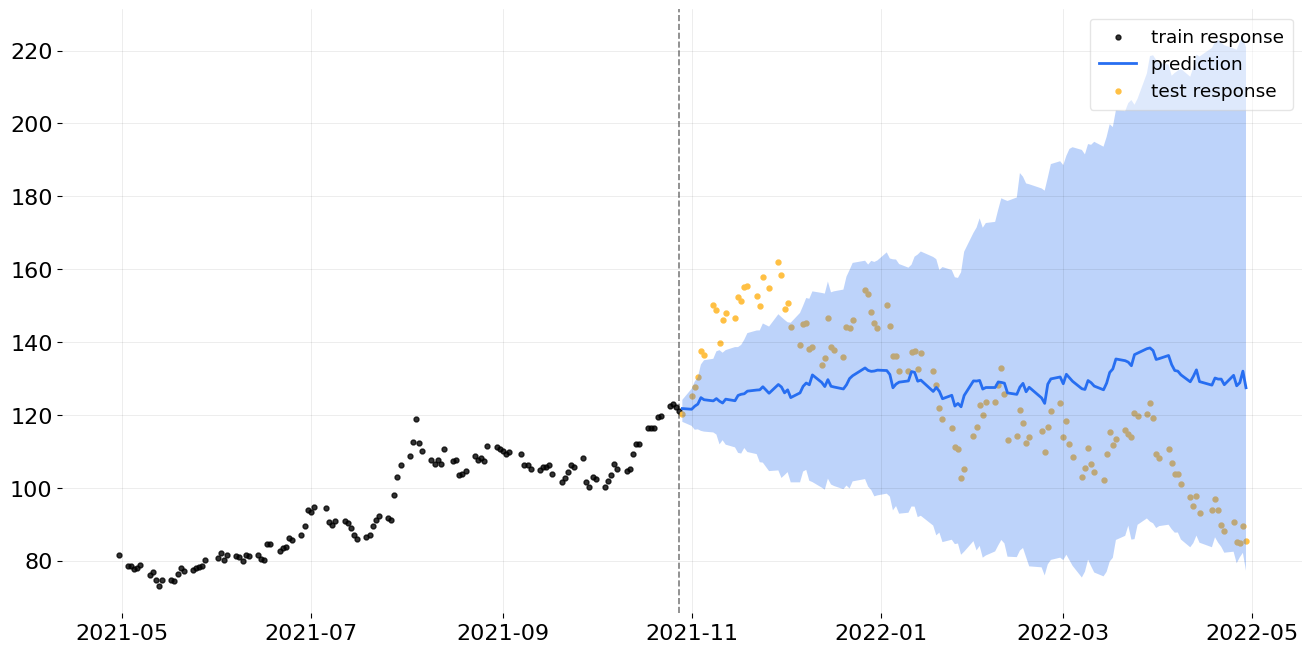

<AxesSubplot:>

In [12]:
plot_predicted_data(
  training_actual_df=stock_price_train, 
  predicted_df=stock_price_predicted, 
  date_col=stock_price_lgt.date_col, 
  actual_col=stock_price_lgt.response_col,
  test_actual_df=stock_price_test
)

#### 2.4.2. Chart LGT Forecast Model Components

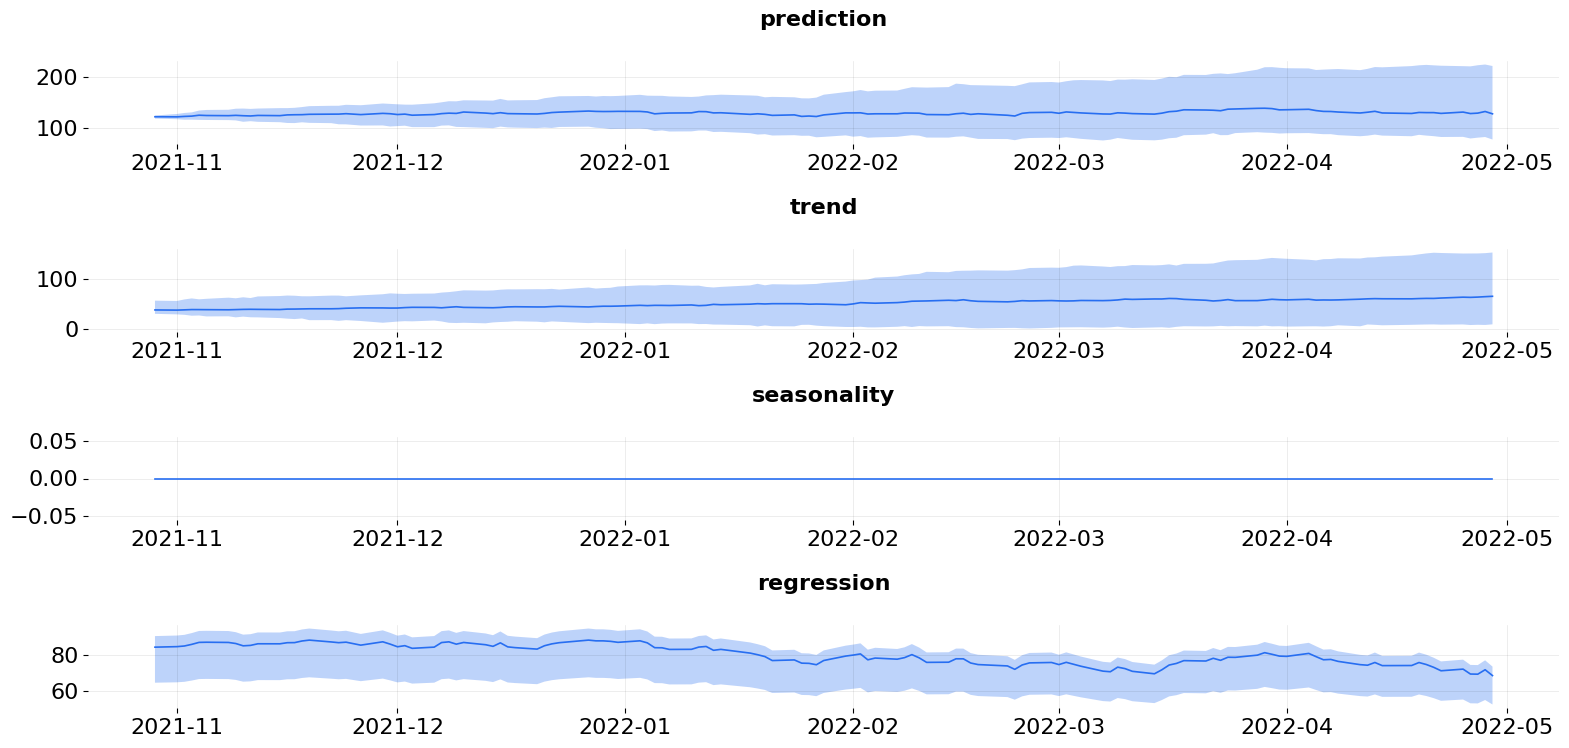

array([<AxesSubplot:title={'center':'prediction'}>,
       <AxesSubplot:title={'center':'trend'}>,
       <AxesSubplot:title={'center':'seasonality'}>,
       <AxesSubplot:title={'center':'regression'}>], dtype=object)

In [13]:
plot_predicted_components(stock_price_predicted, 
                           date_col='Date',
                           plot_components=['prediction', 'trend', 'seasonality', 'regression'])

### 2.5. Validate "Backtest" LGT Forecast Model

Backtesting is where Orbit shines where you can perform either "Rolling" or "Expanded" backtesting easily little coding. Orbit was chosen to develop the forecast model because of this functionality to quickly test out performance of 1 day forecast, 2 day forecast, and so on.

#### 2.5.1. 1 Day Forecast Backtesting

We will be using 20 days of stock price to forecast stock price for 1 day.

<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Split #'>

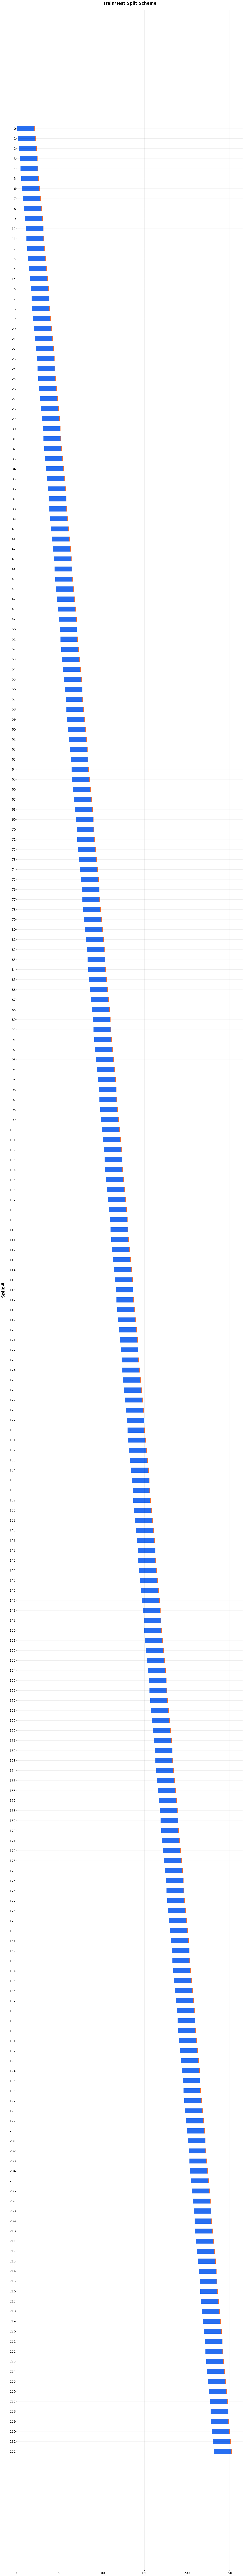

In [14]:
# configs
min_train_len = 20
forecast_len = 1
incremental_len = 1
window_type = 'rolling'

stock_price_bt = BackTester(
    model=stock_price_lgt,
    df=stock_price,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

stock_price_splitter = stock_price_bt.get_splitter()
stock_price_splitter.plot()

In [17]:
%%time
stock_price_bt.fit_predict()

RuntimeError: Initialization failed.

In [18]:
stock_price_bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.020059,False
1,wmape,0.020976,False
2,mape,0.020108,False
3,mse,9.724727,False
4,mae,2.249488,False
5,rmsse,0.768206,False


In [19]:
predicted_df = stock_price_bt.get_predicted_df()
predicted_df.tail(5)

,date,split_key,training_data,actual,prediction
6358,2021-06-23,21,True,83.820000,83.746306
6359,2021-06-24,21,True,86.099998,84.064925
6360,2021-06-25,21,True,85.620003,85.453455
6361,2021-06-28,21,True,87.080002,86.054700
6362,2021-06-29,21,False,89.519997,87.188189


#### 2.5.2. 2 Day Forecast Backtesting

We will be using 20 days of stock price to forecast stock price for 2 days.

<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Split #'>

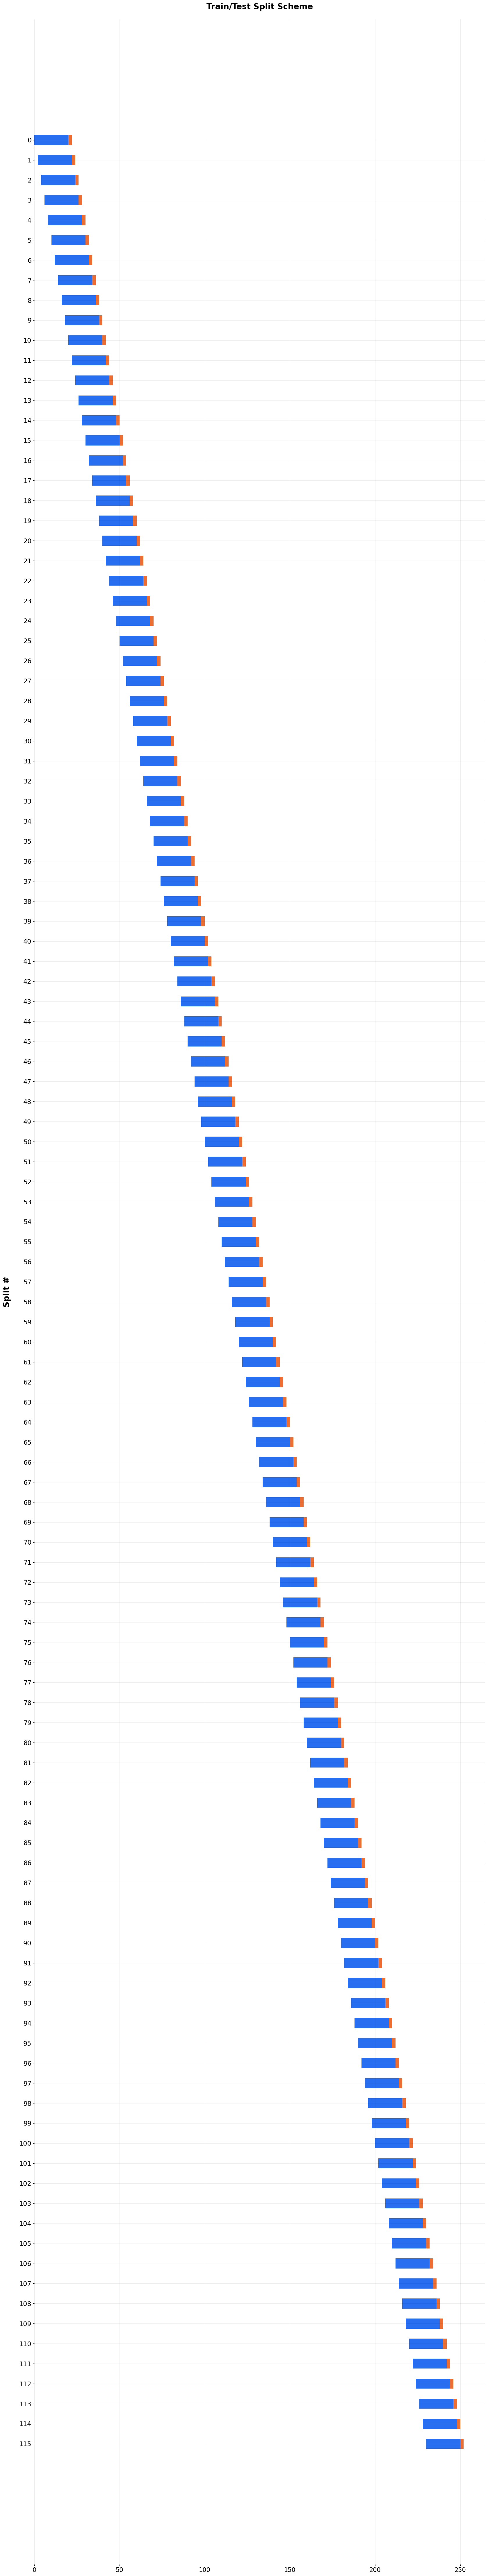

In [20]:
# configs
min_train_len = 20
forecast_len = 2
incremental_len = 2
window_type = 'rolling'

stock_price_bt = BackTester(
    model=stock_price_lgt,
    df=stock_price,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

stock_price_splitter = stock_price_bt.get_splitter()
stock_price_splitter.plot()

In [22]:
%%time
stock_price_bt.fit_predict()

CPU times: user 7.67 s, sys: 6.97 s, total: 14.6 s
Wall time: 6min 39s


In [23]:
stock_price_bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.024876,False
1,wmape,0.025755,False
2,mape,0.024958,False
3,mse,15.489643,False
4,mae,2.884132,False
5,rmsse,1.024288,False


In [24]:
predicted_df = stock_price_bt.get_predicted_df()
predicted_df.tail(5)

,date,split_key,training_data,actual,prediction
2657,2022-04-22,115,True,88.139999,87.550999
2658,2022-04-25,115,True,90.690002,89.377555
2659,2022-04-26,115,True,85.160004,86.462455
2660,2022-04-27,115,False,84.910004,85.856123
2661,2022-04-28,115,False,89.639999,88.852614


#### 2.5.3. 3 Day Forecast Backtesting

We will be using 20 days of stock price to forecast stock price for 3 days.

<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Split #'>

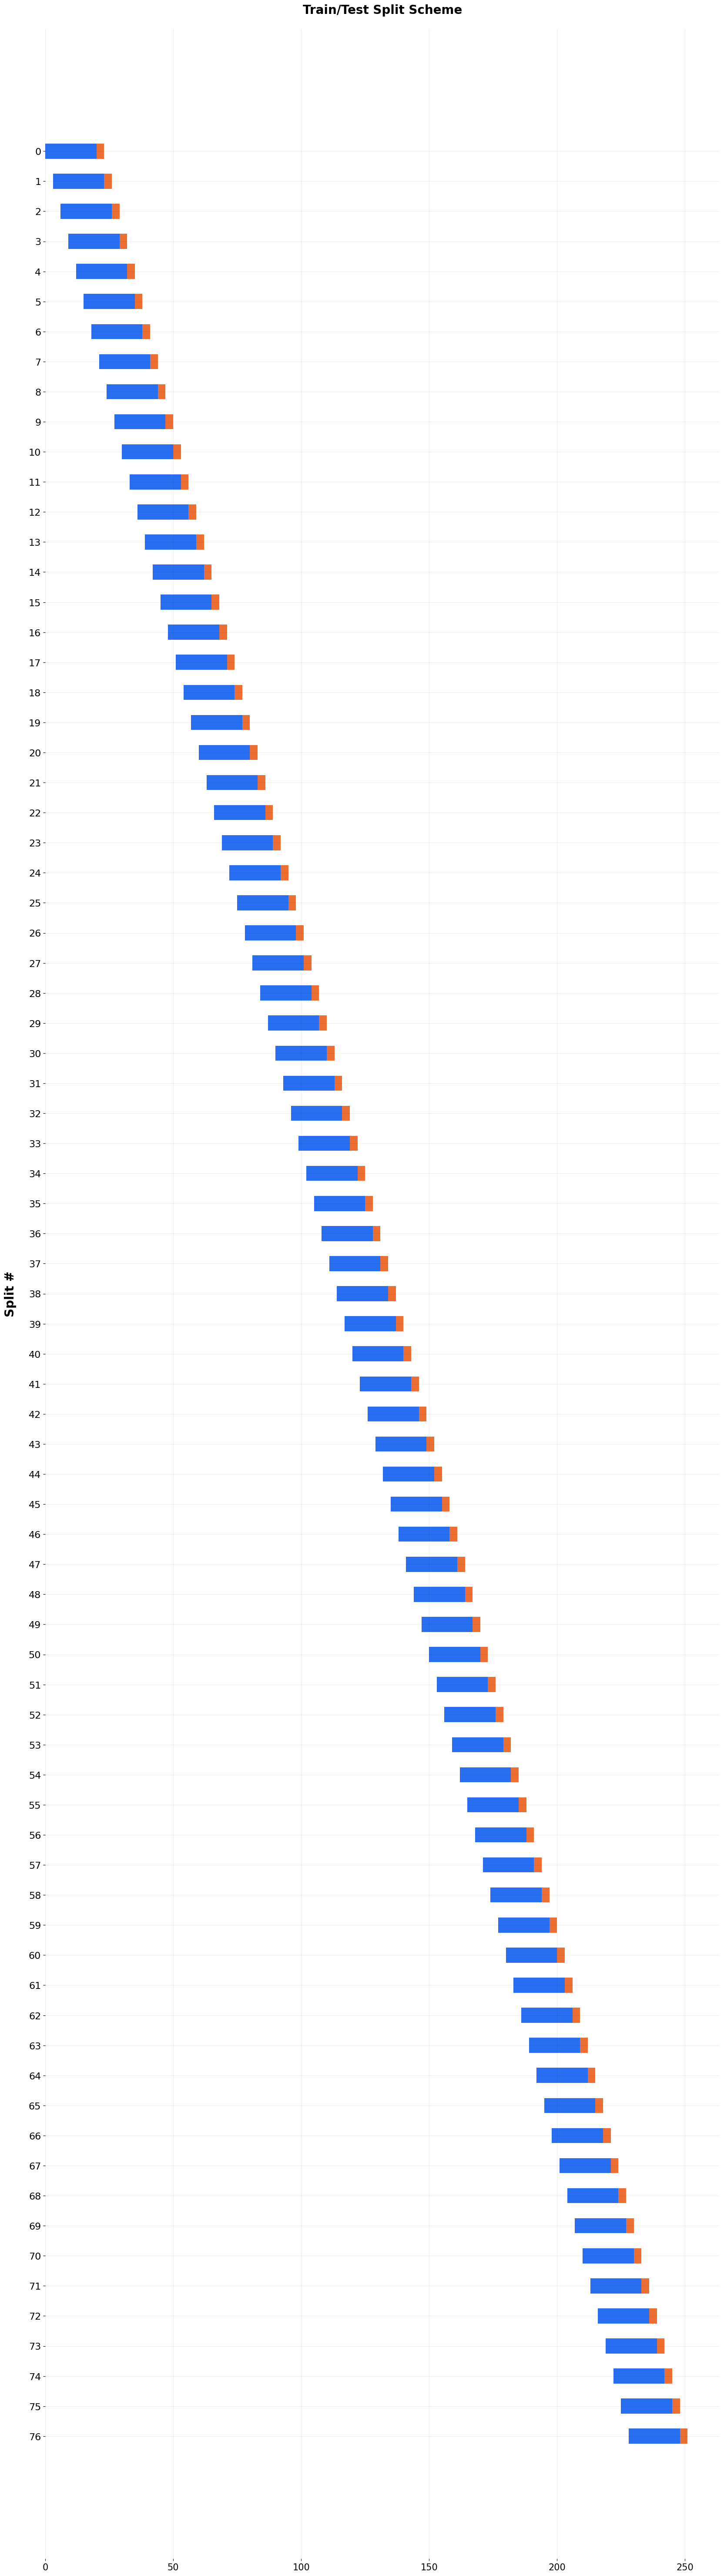

In [25]:
# configs
min_train_len = 20
forecast_len = 3
incremental_len = 3
window_type = 'rolling'

stock_price_bt = BackTester(
    model=stock_price_lgt,
    df=stock_price,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

stock_price_splitter = stock_price_bt.get_splitter()
stock_price_splitter.plot()

In [26]:
%%time
stock_price_bt.fit_predict()

/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:251: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
CPU times: user 4.77 s, sys: 4.2 s, total: 8.96 s
Wall time: 4min 33s


In [27]:
stock_price_bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.028292,False
1,wmape,0.028698,False
2,mape,0.028392,False
3,mse,18.195273,False
4,mae,3.254981,False
5,rmsse,1.089745,False


In [28]:
predicted_df = stock_price_bt.get_predicted_df()
predicted_df.tail(5)

,date,split_key,training_data,actual,prediction
1766,2022-04-21,76,True,89.849998,91.768199
1767,2022-04-22,76,True,88.139999,87.661682
1768,2022-04-25,76,False,90.690002,89.121057
1769,2022-04-26,76,False,85.160004,85.801554
1770,2022-04-27,76,False,84.910004,85.836660


### 2.6. Develop Damped Local Trend (DLT) Forecast Model

In [29]:
%%time
stock_price_dlt = DLT(
  response_col='adj_close', 
  date_col='Date',  
  regressor_col=['nasdaq'],
)
stock_price_dlt.fit(df=stock_price_train)

/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:251: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_05ff738ef22ce2e8a332ce639cee65cf NOW.
CPU times: user 2.23 s, sys: 264 ms, total: 2.49 s
Wall time: 1min 36s


In [30]:
stock_price_predicted = stock_price_dlt.predict(df=stock_price_test, decompose=True)

/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')


#### 2.6.1. Chart DLT Forecast Model

This DLT Forecast Model is not expected to perform well to predict stock price for 6 month, but we are not trying to develop a forecast model to predict stock price for 6 months. We are trying to develop a forecast model to predict stock price for 1 to 5 days.

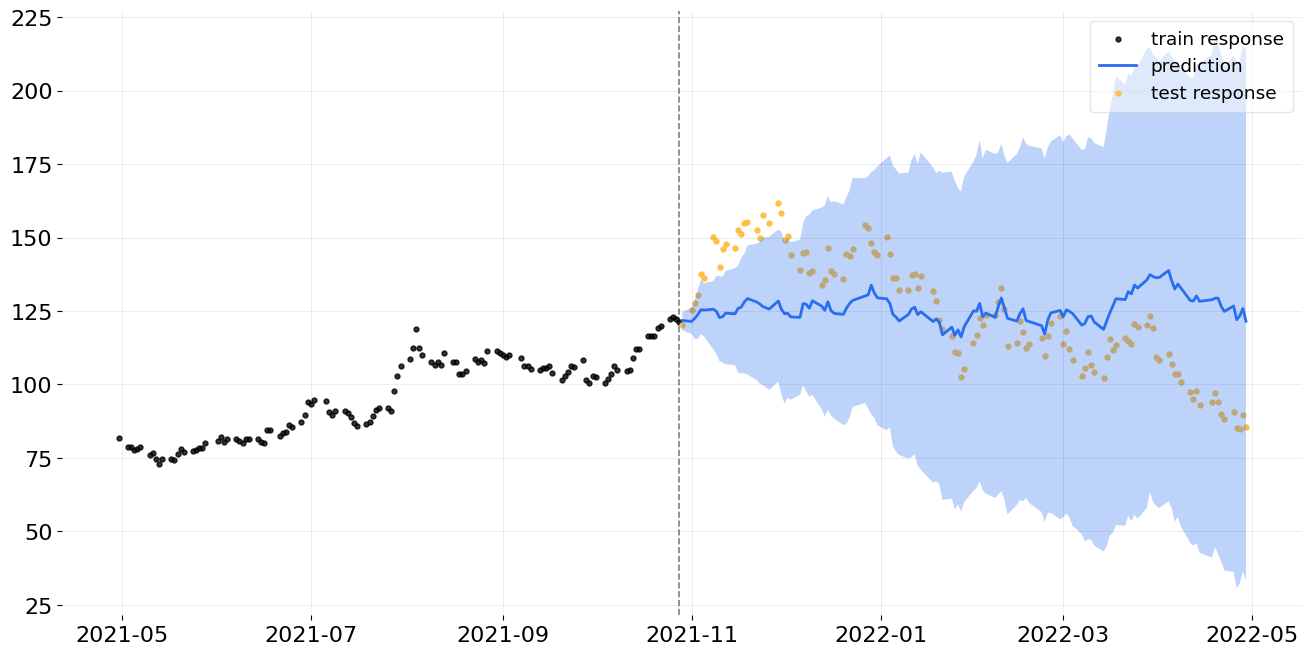

<AxesSubplot:>

In [31]:
plot_predicted_data(
  training_actual_df=stock_price_train, 
  predicted_df=stock_price_predicted, 
  date_col=stock_price_dlt.date_col, 
  actual_col=stock_price_dlt.response_col,
  test_actual_df=stock_price_test
)

#### 2.6.2. Chart DLT Forecast Model Components

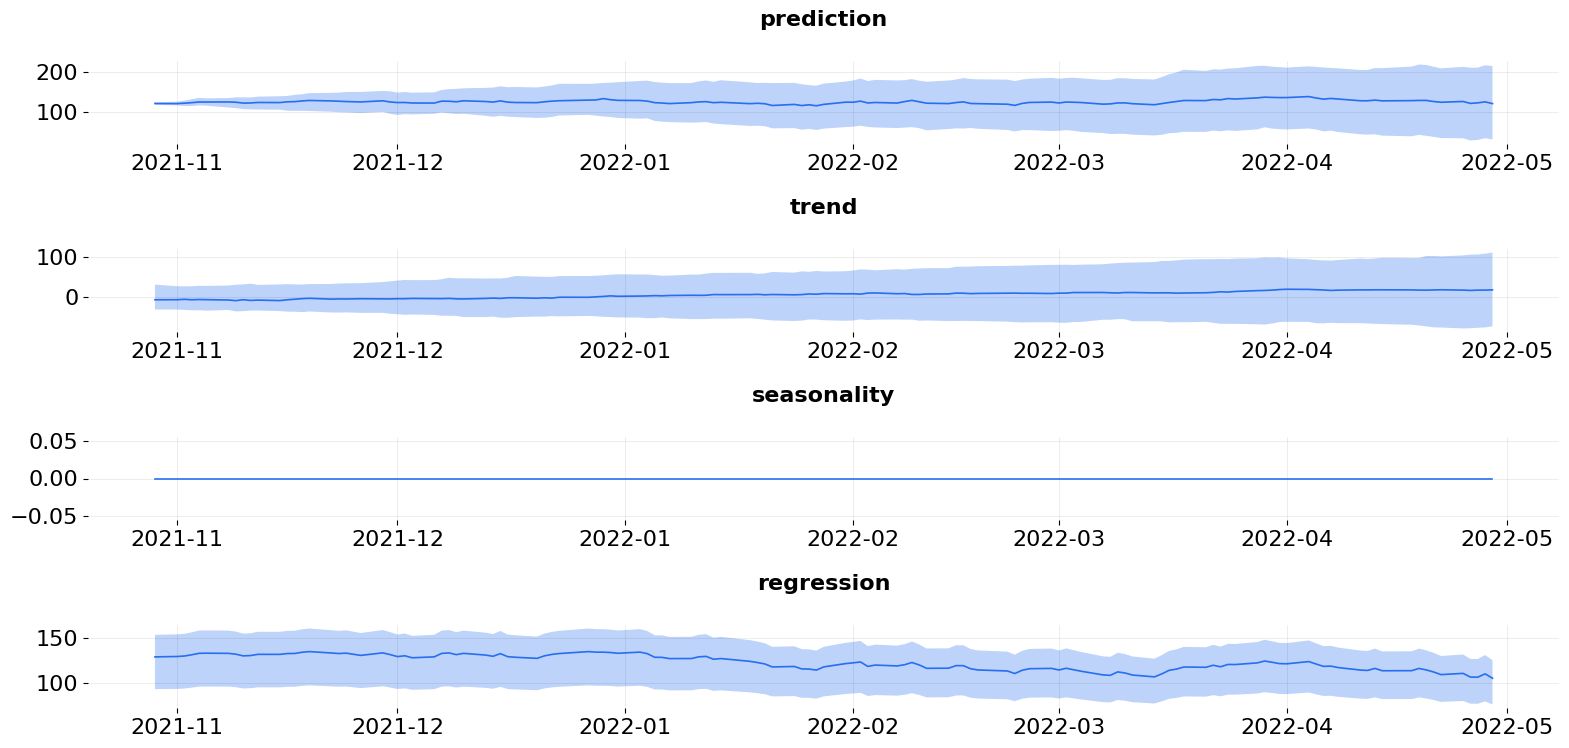

array([<AxesSubplot:title={'center':'prediction'}>,
       <AxesSubplot:title={'center':'trend'}>,
       <AxesSubplot:title={'center':'seasonality'}>,
       <AxesSubplot:title={'center':'regression'}>], dtype=object)

In [32]:
plot_predicted_components(stock_price_predicted, 
                           date_col='Date',
                           plot_components=['prediction', 'trend', 'seasonality', 'regression'])

### 2.7. Validate "Backtest" DLT Forecast Model

Backtesting is where Orbit shines where you can perform either "Rolling" or "Expanded" backtesting easily little coding. Orbit was chosen to develop the forecast model because of this functionality to quickly test out performance of 1 day forecast, 2 day forecast, and so on.

#### 2.7.1. 1 Day Forecast Backtesting

We will be using 20 days of stock price to forecast stock price for 1 day.

<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Split #'>

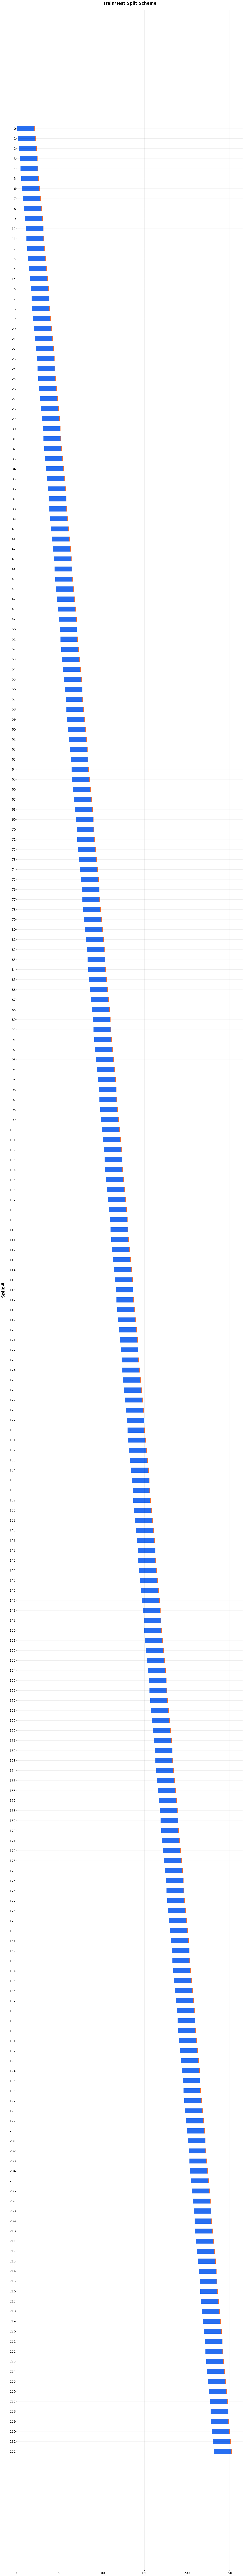

In [33]:
# configs
min_train_len = 20
forecast_len = 1
incremental_len = 1
window_type = 'rolling'

stock_price_dlt_bt = BackTester(
    model=stock_price_dlt,
    df=stock_price,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

stock_price_splitter = stock_price_dlt_bt.get_splitter()
stock_price_splitter.plot()

In [34]:
%%time
stock_price_dlt_bt.fit_predict()

/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:251: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
CPU times: user 12.3 s, sys: 14.8 s, total: 27.1 s
Wall time: 4min 21s


In [35]:
stock_price_dlt_bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.018096,False
1,wmape,0.018530,False
2,mape,0.018119,False
3,mse,8.828482,False
4,mae,2.097640,False
5,rmsse,0.758155,False


In [36]:
predicted_df = stock_price_dlt_bt.get_predicted_df()
predicted_df.tail(5)

,date,split_key,training_data,actual,prediction
4888,2022-04-25,232,True,90.690002,89.274312
4889,2022-04-26,232,True,85.160004,85.194294
4890,2022-04-27,232,True,84.910004,85.122429
4891,2022-04-28,232,True,89.639999,89.734060
4892,2022-04-29,232,False,85.519997,83.322331


#### 2.7.2. 2 Day Forecast Backtesting

We will be using 20 days of stock price to forecast stock price for 2 days.

<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Split #'>

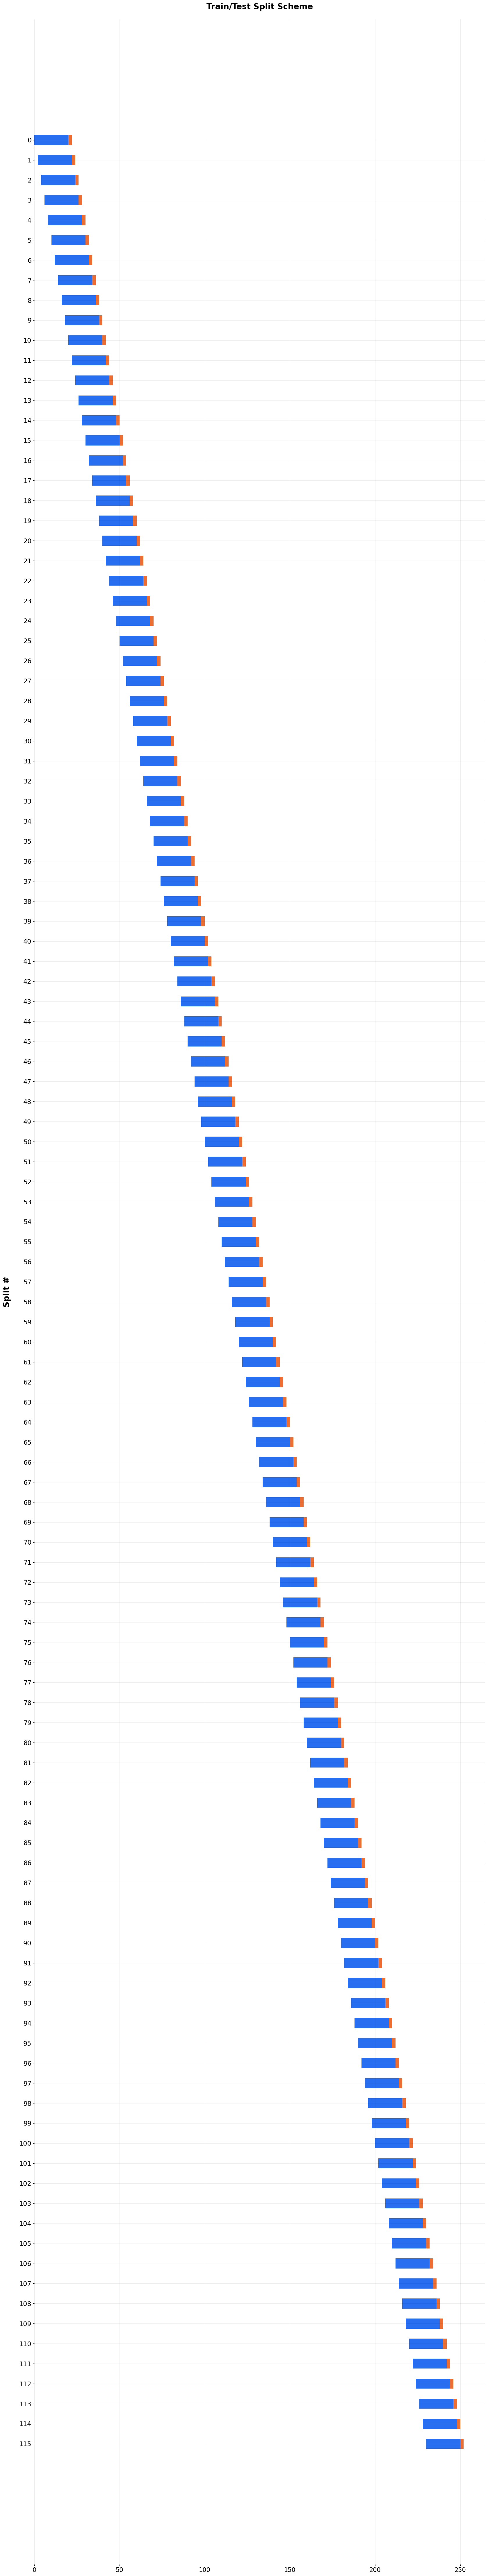

In [37]:
# configs
min_train_len = 20
forecast_len = 2
incremental_len = 2
window_type = 'rolling'

stock_price_dlt_bt = BackTester(
    model=stock_price_dlt,
    df=stock_price,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

stock_price_splitter = stock_price_dlt_bt.get_splitter()
stock_price_splitter.plot()

In [38]:
%%time
stock_price_dlt_bt.fit_predict()

/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:251: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
CPU times: user 6.06 s, sys: 7.72 s, total: 13.8 s
Wall time: 2min 9s


In [39]:
stock_price_dlt_bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.023568,False
1,wmape,0.023997,False
2,mape,0.023617,False
3,mse,14.307492,False
4,mae,2.719393,False
5,rmsse,0.965373,False


In [40]:
predicted_df = stock_price_dlt_bt.get_predicted_df()
predicted_df.tail(5)

,date,split_key,training_data,actual,prediction
2547,2022-04-22,115,True,88.139999,85.744282
2548,2022-04-25,115,True,90.690002,89.496914
2549,2022-04-26,115,True,85.160004,85.285802
2550,2022-04-27,115,False,84.910004,85.084774
2551,2022-04-28,115,False,89.639999,90.141740


#### 2.7.3. 3 Day Forecast Backtesting

We will be using 20 days of stock price to forecast stock price for 3 days.

<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Split #'>

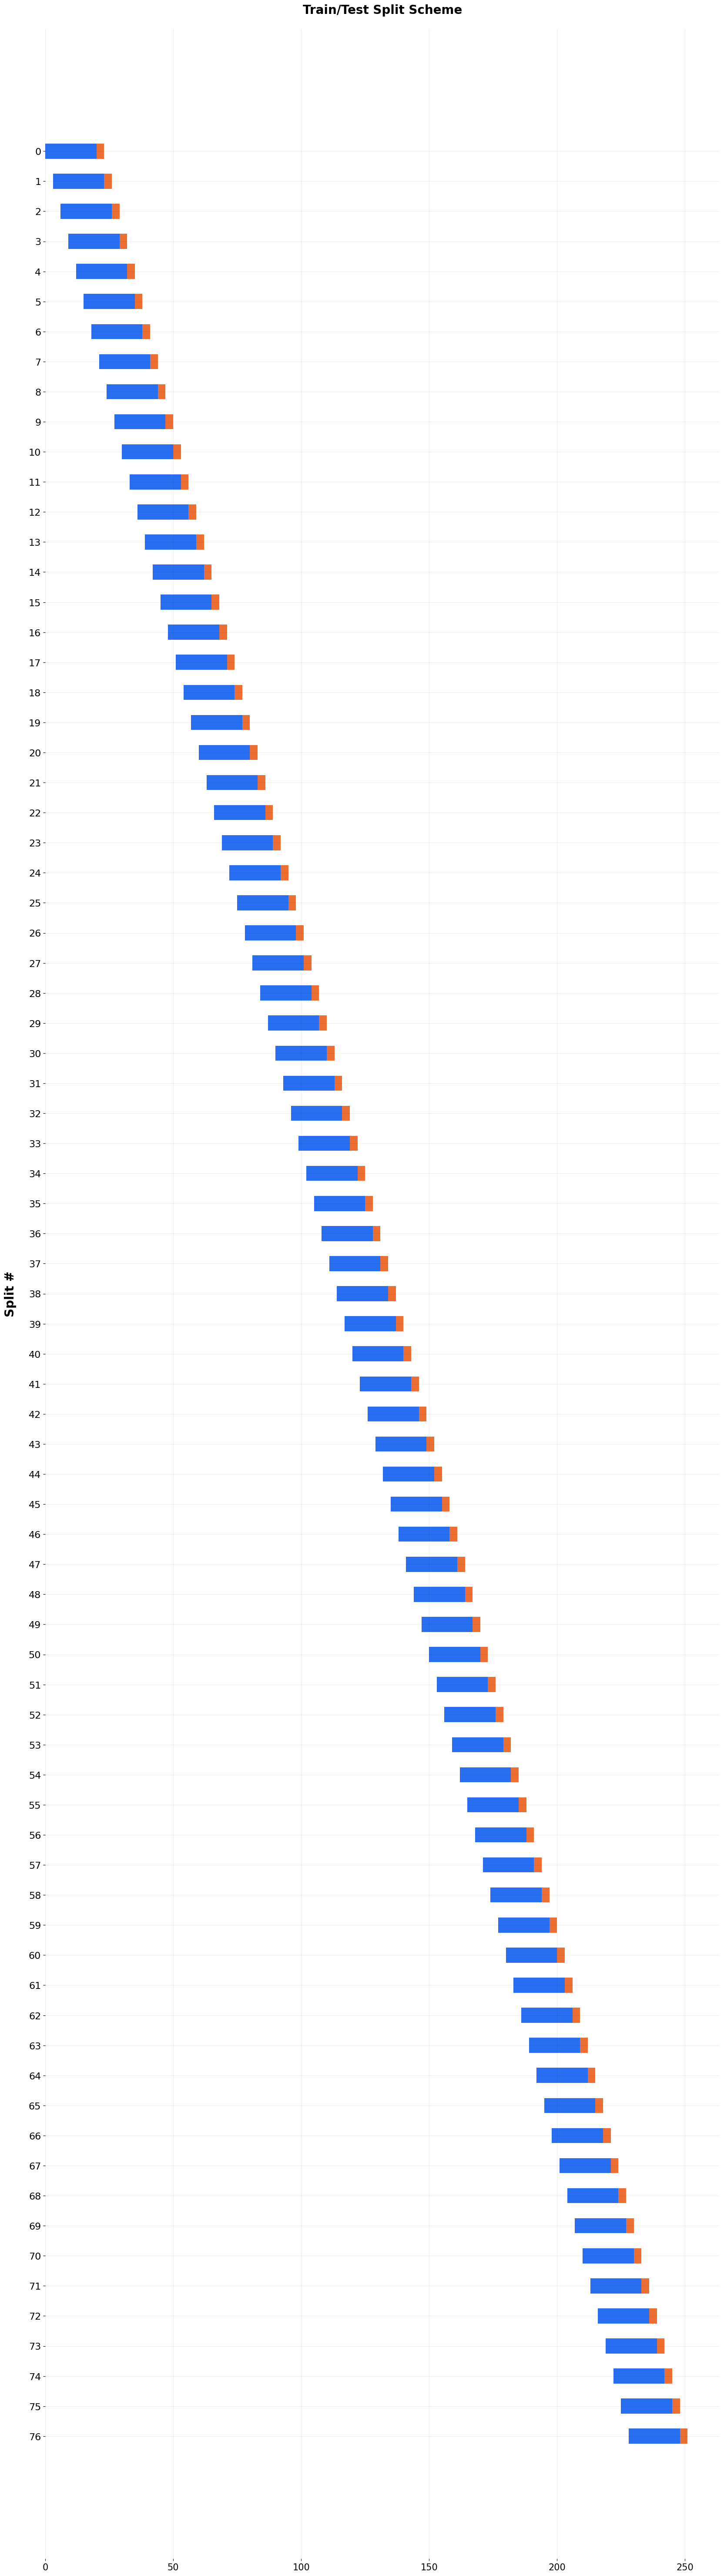

In [41]:
# configs
min_train_len = 20
forecast_len = 3
incremental_len = 3
window_type = 'rolling'

stock_price_dlt_bt = BackTester(
    model=stock_price_dlt,
    df=stock_price,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

stock_price_splitter = stock_price_dlt_bt.get_splitter()
stock_price_splitter.plot()

In [42]:
%%time
stock_price_dlt_bt.fit_predict()

/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
/root/venv/lib/python3.7/site-packages/orbit/forecaster/forecaster.py:251: UserWarning: Datetime index is not evenly distributed
  warnings.warn('Datetime index is not evenly distributed')
CPU times: user 4.16 s, sys: 5.08 s, total: 9.24 s
Wall time: 1min 27s


In [43]:
stock_price_dlt_bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.028056,False
1,wmape,0.028696,False
2,mape,0.028084,False
3,mse,20.077048,False
4,mae,3.254796,False
5,rmsse,1.144711,False


In [44]:
predicted_df = stock_price_dlt_bt.get_predicted_df()
predicted_df.tail(5)

,date,split_key,training_data,actual,prediction
1766,2022-04-21,76,True,89.849998,90.510283
1767,2022-04-22,76,True,88.139999,85.789659
1768,2022-04-25,76,False,90.690002,89.394369
1769,2022-04-26,76,False,85.160004,83.974565
1770,2022-04-27,76,False,84.910004,83.524610


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=94058377-3fbf-47e1-8dd9-fa23e94cc204' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>